In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드 및 전처리

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # -1 to 1 범위로 정규화
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

Files already downloaded and verified


# U-Net 모델 정의

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # 인코더 (Contracting Path)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        )
        
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        )
        
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        # 병목층 (Bottleneck)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # 디코더 (Expanding Path)
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 4x4 -> 8x8
        )
        
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 8x8 -> 16x16
        )
        
        self.decoder_3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 16x16 -> 32x32
        )
        
        # 최종 출력 레이어
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)  # 출력 채널 3 (RGB 이미지)

    def forward(self, x):
        # 인코더
        enc1 = self.encoder(x)
        enc2 = self.encoder_2(enc1)
        enc3 = self.encoder_3(enc2)
        
        # 병목층
        bottleneck = self.bottleneck(enc3)
        
        # 디코더
        dec1 = self.decoder_1(bottleneck)
        dec2 = self.decoder_2(dec1)
        dec3 = self.decoder_3(dec2)
        
        # 최종 출력
        out = self.final_conv(dec3)
        return out

# 모델 초기화
model = UNet().cuda()

# 손실 함수와 최적화 알고리즘

In [6]:
criterion = nn.MSELoss()  # 평균 제곱 오차 (복원된 이미지와 원본 이미지 간의 차이)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# 학습 함수
def train_model(model, trainloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in trainloader:
            inputs, _ = data  # 레이블은 필요 없음
            inputs = inputs.cuda()

            # 손상된 이미지 생성 (노이즈 추가)
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            noisy_inputs = torch.clip(noisy_inputs, 0., 1.)  # 값이 0~1 사이로 유지되도록 조정

            optimizer.zero_grad()

            # 모델에 손상된 이미지 입력
            outputs = model(noisy_inputs)
            
            # 손실 계산
            loss = criterion(outputs, inputs)  # 원본 이미지와 복원된 이미지 간의 차이
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader)}')

# 모델 학습
train_model(model, trainloader, epochs=5)

Epoch [1/5], Loss: 0.10282254917428012
Epoch [2/5], Loss: 0.06135226470773177
Epoch [3/5], Loss: 0.05047508166707538
Epoch [4/5], Loss: 0.0455700719819578
Epoch [5/5], Loss: 0.042636753624433754


# 이미지 결과 확인 함수

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46666664..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70492893..0.72508657].


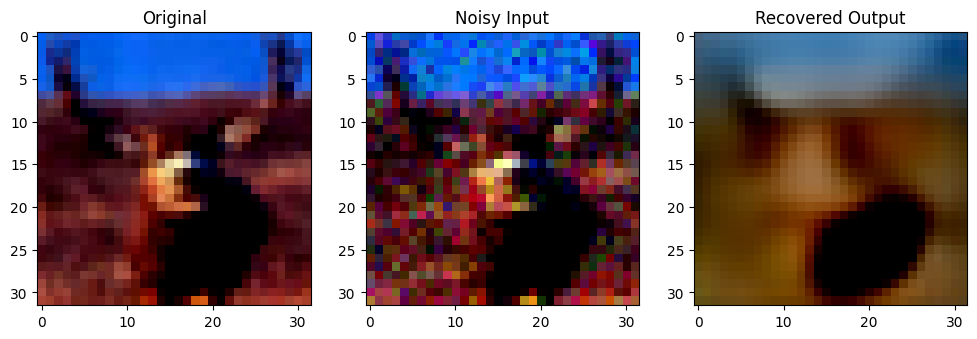

In [8]:

def show_images(original, noisy, output):
    # 결과 이미지를 시각화
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(original.permute(1, 2, 0).cpu().detach().numpy())
    ax[0].set_title('Original')
    ax[1].imshow(noisy.permute(1, 2, 0).cpu().detach().numpy())
    ax[1].set_title('Noisy Input')
    ax[2].imshow(output.permute(1, 2, 0).cpu().detach().numpy())
    ax[2].set_title('Recovered Output')
    
    plt.show()

# 학습된 모델로 테스트 이미지 확인
model.eval()
with torch.no_grad():
    data_iter = iter(trainloader)
    images, _ = next(data_iter)
    noisy_images = images + 0.1 * torch.randn_like(images)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    
    outputs = model(noisy_images.cuda())
    
    # 첫 번째 배치의 이미지 1개만 보여주기
    show_images(images[0], noisy_images[0], outputs[0].cpu())
